# 1. Introduction

In this notebook, we will use unsupervised learning techniques to explore the macroeconomic patterns in national economies over the past 60 years. Key economic data can be _missing_ (e.g., there are political incentives for obscuring unemployment data), especially in earlier years before data collection became more standardized. We use _matrix completion_ to impute this missing data. If we look at more than two or three metrics, then this data will also be _high-dimensional_. We use _principal component analysis_ to reduce data dimensionality while preserving the most important structural information. By appling _clustering methods_ to macroeconomic indicators, we aim to identify the distinct economic states/phases that countries experience, from periods of steady growth to periods of severe recession or hyperinflation.

The data was sourced from the [World Bank Group](https://www.worldbank.org/ext/en/home), an international financial institution that gives loans and grants to low and middle-income countries. We consider the following four indicators across all available countries from the years 1960 to 2024:
- **Current account balance** (% of GDP): Measures a country's net trade/income with the rest of the world. A CAB _surplus_ means that an economy is a net _creditor_ to the rest of the world, providing resources to other economies and being owed money in return. A CAB _deficit_ means that an economy is a net _debtor_ to the rest of the world, investing more than it's saving and borrowing resources from other economies to fuel its domestic consumption.
- **GDP per capita annual growth** (%): Captures changes in living standards and economic performance on a per-person basis. This metric signals whether citizens are becoming richer or poorer.
- **Inflation** (consumer prices): Reflects monetary stability and price dynamics within an economy. Exceedingly high inflation or deflation signals economic instability.
- **Unemployment rate** (ILO estimate): Measures labor market health and social economic conditions. Economic downturns and high unemployment often appear together.

We intentionally selected indicators that have been normalized in some way so as to maximize comparability across different time periods and countries. For example, we use GDP per capita growth rather than absolute measures of GDP (per capita), which would make it difficult to compare the dynamics of large and small economics or across different time periods (GDP and GDP per capita naturally increase over time). Similarly, we use International Labor Organization (ILO) unemployment estimates rather than national estimates because (1) ILO data is more complete (there can be political incentives to obscure unemployment statistics), and (2) the methodology for calculating unemployment can vary across countries and time, undermining direct comparison. The indicators were sourced _individually_ and can be found in their respective directories under `data/source`.

# 2. Theoretical Background

In **supervised learning**, the dataset contains both _predictors_ and _response_ variables, and the goal is to predict the response variable with the predictors. In **unsupervised learning** we are only provided a set of features, but no labels. Rather than prediction, the goal is to discover structure within the data (e.g., does the data cluster into subgroups). The lack of ground-truth labels makes unsupervised learning challenging because, unlike in supervised learning, there isn't a clear goal or way to assess the quality of results. For example, it's hard to tell how whether an approximation obtained from _matrix completion_ is good or bad because we don't have the true values to compare against.

## 2.1 Principal Component Analysis

### 2.1.1 Principal Components

The **principal components** of a dataset are the (orthogonal) directions of maximum variance in the data, that is, the directions along which the data separates the most. **Principal component analysis** (PCA) is the process by which which principal components are computed and the subsequent use of these components in understanding the data. The idea is that, while our data lives in $p$-dimensional space, not all of these dimensions are equally interesting or important. PCA finds the most interesting dimensions (where the concept of "interesting" is measured by variance), allowing us to reduce data dimensionality while still retaining most of the structure. PCA can be used in feature engineering for supervised learning problems, dimensionality reduction for data visualization and low-rank approximations, and data imputation (i.e., filling missing values in a matrix).

As mentioned above, the principal components are the _orthogonal_ directions of maximum variance in the data. For example, the _first_ principal component is the direction of highest variance, and the _second_ principal component is the direction of _second_ highest variance orthogonal to the first principal component, that is, it's the direction of highest _unexplained_ variance (and so on for the remaining principal components). More technically, the $i^{\text{th}}$ principal component is the _direction_ $\hat{v}_i$ that is orthogonal to the first $i-1$ principal components and maximizes the variance of the sample _scores_ $s_i=\hat{v}_i^\top \vec{x}_i$.

<p align="center">
	<img src="img/Screenshot 2025-05-25 221346.png" width="600">
</p>

The coefficients of the principal components, called the **loadings**, tell us each feature's contribution to a particular principal component, which can reveal important structure in the data (e.g., which features contribute the most to a component, and the relationship between features in a component). The **scores** are the projection of the data onto the principal components. In other words, the scores give us the coordinates of each data point in the basis of the principal components. The scores of the first $M$ principal components gives us the "best" $M$-dimensional view of the data in the sense that they form a basis for the $M$-dimensional subspace that best fits the data (in terms of average Euclidean distance). Using only the first $M$ principal components can be used to obtain low dimensional representations of high-dimensional data while preserving the most important structure in the data.

<p align="center">
	<img src="img/Screenshot 2025-05-25 221707.png" width="600">
</p>

### 2.1.2 Proportion of Variance Explained

A natural question is, how much of the information in a given dataset is lost by projecting the observations onto the first few principal components? That is, how much of the variance in the data is _not_ contained in the first few principal components? More generally, we're interested in knowing the **proportion of variance explained** (PVE) by each principal component. The PVE of the $m^{\text{th}}$ principal component is given by the variance of its scores divided by the total variance of the data: (assuming the features have been centered to have zero mean) $$\frac{\sum_{i=1}^n s^2_{im}}{\sum_{j=1}^p \mathbb{V}(X_j)}=\frac{\sum_{i=1}^n \left(\hat{v}_m^\top\vec{x}_i\right)^2}{\frac{1}{n}\sum_{j=1}^p \sum_{i=1}^n x_{ij}^2}$$
The **cumulative proportion of variance explained** (CPVE) of the first $M$ principal components, given by the sum of the first $M$ PVEs, is the proportion of variance explained by the first $M$ principal components collectively. This information can be used to intelligently choose the number of principal components to use.

<p align="center">
	<img src="img/Screenshot 2025-05-26 010541.png" width="600">
</p>

### 2.1.3 Singular Value Decomposition

The **singular value decomposition** (SVD) of a matrix is a factorization that can be used to obtain low-rank matrix approximations and implement PCA.

> **Singular Value Decomposition**
>
>Let $A\in\mathbb{R}^{m\times n}$ and $r=\text{rank}(A)$. The **full singular value decomposition** of $A$ is given by $A=U\Sigma V^\top$, where:
>- $U\in\mathbb{R}^{m\times m}$ is an orthonormal matrix whose first $r$ columns form an orthonormal basis for $\text{Col}(A)$ and whose last $m-r$ columns form an orthonormal basis for $\text{Null}(A^\top)$
>- $V\in\mathbb{R}^{n\times n}$ is an orthonormal matrix whose first $r$ columns form an orthonormal basis for $\text{Row}(A)$ and whose last $n-r$ columns form an orthonormal basis for $\text{Null}(A)$
>- $\Sigma\in\mathbb{R}^{m\times n}$ is the matrix with the positive **singular values** $\sigma_1,\ldots,\sigma_r>0$ as the first diagonal elements (and 0's elsewhere), where $\sigma_1^2,\ldots,\sigma_r^2>0$ are the nonzero eigenvectors of $A^\top A$
>
>The **reduced singular value decomposition** of $A$ simply drops the last $m-r$ columns of $U$, the last $n-r$ columns of $V$, and trims $\Sigma$ to be the $r\times r$ diagonal matrix with $\sigma_1,\ldots,\sigma_r$ along its diagonal.

>**Low Rank Approximation**
>
>Let $A$ be a rank $r$ $m\times n$ matrix with SVD $A=U\Sigma V^\top$. The rank $k<r$ approximation of $A$ is given by the reduced SVD $A_k=U_k\Sigma_kV^\top_k$, where
>- $U_k\in\mathbb{R}^{m\times k}$ contains the first $k$ columns of $U$
>- $\Sigma_k\in\mathbb{R}^{k\times k}$ contains the first $k$ singular values
>- $V_k^\top\in\mathbb{R}^{k\times n}$ contains the first $k$ rows of $V^\top$
>
>$\hat{A}=A_k$ is the best rank-$k$ approximation of $A$ in the sense that it minimizes the Frobenius distance between $A$ and $\hat{A}$ (which is equivalent to the Euclidean distance between the flattened matrices).

>**SVD Implementation of PCA**
>
>SVD implements PCA when the data is standardized. Let $X\in\mathbb{R}^{m\times n}$ be a data matrix storing $m$ samples of $n$ standardized features, and let $X=U\Sigma V^\top$ be its reduced singular value decomposition. Then
>- The $m^{\text{th}}$ principal component is the $m^{\text{th}}$ row of $V^\top$
>- The PVE of the $m^{\text{th}}$ principal component is $\sigma_m^2/(n-1)$
>- The scores of the $i^{\text{th}}$ sample is the $i^{\text{th}}$ row of $S=U\Sigma$
>- The **standardized score** of the $i^{\text{th}}$ sample is $i^{\text{th}}$ row of $U$
>	- The "standardization" treats all principal axes are equally important by not scaling them by the singular values.

## 2.2 Matrix Completion

Datasets often having missing values, which is something that has to be addressed before most statistical learning methods can be applied. One solution is to just remove the rows that contain missing observations, but this seems wasteful and can be unrealistic depending on the fraction missing. Another approach is to replace missing values with the mean of the non-missing entries in its column. Although this is a common and convenient strategy, we can do better by taking advantage of the correlation between variables. **Matrix completion** uses principal components to impute missing values. This approach is appropriate if the missingness is random; if the missingness is meaningful or systematic, then this approach is not suitable.

>**Hard-Impute: Iterative Algorithm for Matrix Completion**
>
> 1. Create a complete data matrix $\tilde{X}\in\mathbb{R}^{n\times p}$ with $$\tilde{x}_{ij}=\left\{\begin{array}{lr}x_{ij} & (i,j)\in\mathcal{O} \\ \bar{x}_j & (i,j)\notin\mathcal{O}\end{array}\right.$$ where $\mathcal{O}$ indexes the observed values and $\bar{x}_j$ is the average of the observed values for $j^{\text{th}}$ variable
>
> 2. Repeat until the objective stops decreasing:
>       - Compute the rank-$M$ approximation of $\tilde{X}$: $\tilde{X}_M=U_M\Sigma_M V^\top_M$
> 	    - Set $x_{ij}\leftarrow (\tilde{X}_M)_{ij}$ for each $(i,j)\in\mathcal{O}$
> 	    - Compute the objective $\sum_{(i,j)\in\mathcal{O}} (x_{ij}-\tilde{x}_{ij})^2$
>
> 3. Return $\tilde{X}$

## 2.3 Clustering Methods

**Clustering** refers to a broad set of techniques for finding **clusters** (subgroups) in a dataset. When we cluster the observations of a dataset, we're trying to split them into distinct groups so that the observations within the same group are similar to each other, while the observations in different groups are different from each other.

### 2.3.1 K-Means Clustering

**K-means clustering** is a simple approach for splitting the observations into a pre-specified number of clusters. The main idea is that a good clustering is one that minimizes the total within-cluster variation, $\sum_k W(C_k)$, where the **within-cluster variation** of a cluster $C_k$ is a measure $W(C_k)$ of the amount the observations within a cluster differ from each other. While there are many ways to define the within-cluster variation $W(C_k)$, the most common choice is to use the **within-cluster sum of squares** (WCSS) divided by the number of observations in the cluster: $$W(C_k)=\frac{1}{\lvert C_k\rvert}\sum_{i,i'\in C_k}\lvert \vec{x}_i-\vec{x}_{i'}\rvert^2$$

>**K-Means Clustering**
>
>1. Randomly assign a number from $1$ to $K$ to each of the observations. These serve as initial cluster assignments for the observations.
>2. Repeat until the cluster assignments stop changing:
>		- For each of the $K$ clusters, compute the cluster **centroid** (the mean of the observations assigned to that cluster)
>		- Assign each observation to the cluster whose centroid is closest

<p align="center">
	<img src="img/Screenshot 2025-05-26 112234.png" width="400">
</p>

The algorithm above finds a _local_ optimum (not a _global_ optimum) based on the random initialization. Thus, it is important to run the algorithm multiple times (with different initializations) and then choose the clustering with minimal within-cluster variation.

In K-means clustering, we have to pre-specify the number of clusters to find. But how do we know which choice of $K$ is best? Performing clustering on a dataset will _always_ find clusters, but how do we know if these clusters represent true subgroups in the data or if they're just a result of clustering the noise? One approach is to plot metrics that measure cluster quality (like the within-cluster sum of squares or the _silhouette score_) as a function of $K$ and choose the value of $K$ that achieves a reasonable tradeoff between cluster quality and number of clusters (e.g., the elbow method).

### 2.3.2 Hierarchical Clustering

One disadvantage of K-means clustering is that it requires us to pre-specify the number of clusters $K$. In **hierarchical clustering** we don't know in advance how many clusters we want. Instead, we construct a tree-based representation of the _hierarchical_ clustering (called a **dendrogram**) that allows us to view the clustering for all possible choices of $K$.

<p align="center">
	<img src="img/Screenshot 2025-05-26 122356.png" width="600">
</p>

Each leaf of the dendrogram represents one observation in the dataset. As we move up the tree, leaves fuse into branches. The earlier (lower in the tree) fusions occur, the more similar the groups of observations are to each other; the later (higher in the tree) fusions occur, the more dissimilar the groups are to each other. Clusters can be extracted from a dendrograms by making a horizontal cut and taking the branches as clusters. Cutting the dendrogram at a higher level results in fewer, larger clusters, with observations in the same cluster being more dissimilar; cutting the dendrogram at a lower level results in more, smaller clusters, with observations in the same cluster being less dissimilar. The term _hierarchical_ refers to the fact that clusters obtained by cutting the dendrogram at a given height are necessarily nested within the clusters obtained by cutting the dendrogram at a greater height (which isn't always a realistic assumption).

The most common type of hierarchical clustering is **agglomerative clustering**, which constructs dendrograms from the bottom-up by initially treating each observation as its own cluster and progressively merging the two least dissimilar clusters until only a single cluster remains.

>**Agglomerative Clustering**
>
>1. Being with $n$ observations and a measure of all pairwise dissimilarities (e.g., Euclidean distance). Treat each as its own cluster.
>
>2. For $k=n,n-1,\ldots,2$:
>	    - Examine all pairwise inter-cluster dissimilarities among the $k$ clusters, identify the pair of clusters that are least dissimilar, and then fuse these two clusters (the dissimilarity between these two clusters indicates the height in the dendrogram at which the fusion occurs)
>	    - Compute the new pairwise inter-cluster dissimilarities among the $k-1$ remaining clusters

The algorithm above requires the concept of dissimilarity between a pair of observations be extended to a pair of _groups of observations_. This extension is achieved by the notion of **linkage**. The four most common types of linkage are:
- **Complete Linkage**: Maximal inter-cluster dissimilarity. Compute all pairwise dissimilarities between the observations in two clusters, and record the largest of these dissimilarities.
- **Single Linkage**: Minimal inter-cluster dissimilarity. Compute all pairwise dissimilarities between the observations in two clusters, and record the smallest of these dissimilarities. Single linkage can result in extended, trailing clusters in which single observations are fused one-at-a-time.
- **Average Linkage**: Mean inter-cluster dissimilarity. Compute all pairwise dissimilarities between the observations in two clusters, and record the average of these dissimilarities.
- **Centroid Linkage**: Dissimilarity between the centroids of two clusters. Centroid linkage can result in undesirable _inversions_.

The choice of linkage can have a strong effect on the resulting dendrogram and should be chosen carefully based on the characteristics of the data and the goals of analysis. Average and complete linkage are generally preferred because they tend to yield more balanced dendrograms.

# 3. Methodology

Each of the four indicators were sourced _individually_, meaning that they each have their own CSV file. So, the first step is to merge the indicators into a single dataset. As it turns out, the source files also have data entries for non-entities (e.g., categories like "Low & middle income"); these have to be removed manually. We do both of these preliminary data cleaning steps in `data/script.ipynb`. We finish the data cleaning and preprocessing in [Section 4.1](#41-Data-Cleaning-and-Preprocessing), dropping the rows missing two or more indicators, using the Hard-Impute matrix completion algorithm to fill the remaining missing values, and standardizing the features to have mean 0 and standard deviation 1. It's worth mentioning that matrix completion will likely be _uneffective_ for this data because missingness of data is _not_ random. Ideally, we would either use external data sources to fill in the gaps or more sophisticated, domain-specific techniques for imputing the features, but we'll just use matrix completion for simplicity (and because it's part of the assignment).

In [Section 4.2](#42-PCA), we use singular value decomposition to perform principal component analysis on the data. First, we plot the proportion of variance explained (PVE) and cumulative proportion explained (CPVE) to see the share of variance captured by the principal components and how much of the variance we'd lose when using only the first two components (e.g., for plotting). We then look at the loadings of the principal components, which tells use each features contribution to a principal component and its relationship to the other features in that component. In particular, the loadings can be useful in interpreting and giving meaningful names to the principal components. Finally, we plot the data in (1) inflation and GDP per capita growth, and (2) the first two principal components to see how they compare and whether the data forms clear clusters.

In [Section 4.3](#43-K-Means-Clustering), we use K-Means clustering to cluster the data, using within-cluster sum of squares and silhouette scores to choose the number of clusters. We then plot the clustering (color-coded) in the first two principal components and look at some of the samples in the clusters to try to interpret what the clusters _mean_. Ideally, the clusters would cleanly correspond to economic states such as recession or hyperinflation. In [Section 4.4](#44-Hierarchical-Clustering), we cluster the data using hierarchical (agglomerative) clustering, and compare the hierarchical clustering against the k-means clustering with a confusion table and plots.

# 4. Implementation and Results

## 4.1 Data Cleaning and Preprocessing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/processed/data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11651 entries, 0 to 11650
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            11651 non-null  object 
 1   year               11651 non-null  int64  
 2   cab                7442 non-null   float64
 3   gdp_percap_growth  10999 non-null  float64
 4   inflation          8904 non-null   float64
 5   unemployment       6349 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 546.3+ KB


In [ ]:
# The cab and unemployment features are especially sparse
df.isna().sum()/len(df)

country              0.000000
year                 0.000000
cab                  0.361257
gdp_percap_growth    0.055961
inflation            0.235774
unemployment         0.455068
dtype: float64

In [ ]:
# drop rows missing 2 or more indicators
df = df.dropna(thresh=5).reset_index(drop=True)
df.info()  # dropped ~36% of the rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7416 entries, 0 to 7415
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            7416 non-null   object 
 1   year               7416 non-null   int64  
 2   cab                6925 non-null   float64
 3   gdp_percap_growth  7386 non-null   float64
 4   inflation          7190 non-null   float64
 5   unemployment       5580 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 347.8+ KB


In [5]:
# much better (unemployment is still spotty, though)
df.isna().sum()/len(df)

country              0.000000
year                 0.000000
cab                  0.066208
gdp_percap_growth    0.004045
inflation            0.030475
unemployment         0.247573
dtype: float64

In [6]:
country_year = df[["country","year"]]
X = df[["cab","gdp_percap_growth","inflation","unemployment"]]

In [7]:
X.index = country_year.apply(lambda row: f"{row.country}, {row.year}", axis=1)
X[:3]

,cab,gdp_percap_growth,inflation,unemployment
"Afghanistan, 2005",NaN,7.383377,12.686269,7.885
"Afghanistan, 2006",NaN,1.132485,6.784597,7.914
"Afghanistan, 2007",NaN,11.692303,8.680571,7.817


In [8]:
def impute_with_col_means(X):
    X_ = X.copy()
    col_means = np.nanmean(X_, axis=0)
    missing_idx = np.where(np.isnan(X_))  # (row_indices, col_indices)
    X_[missing_idx] = np.take(col_means, missing_idx[1])
    return X_

def fit_svd(X, M):
    U, s, VT = np.linalg.svd(X,full_matrices=False)
    return U[:, :M] @ (np.diag(s[:M]) @ VT[:M, :]) 

# X should be scaled
def matrix_completion(X, rel_error_threshold, M, max_iterations=10, verbose=False):
    missing_idx = np.isnan(X)
    X_tilde = impute_with_col_means(X)

    mss0 = np.mean(X[~missing_idx]**2)
    mss_prev = None
    iteration = 0
    rel_error = rel_error_threshold+1
    while rel_error>rel_error_threshold and iteration<max_iterations:
        iteration += 1

        X_tilde_M = fit_svd(X_tilde,M)  # M-rank approximation of X_tilde
        X_tilde[missing_idx] = X_tilde_M[missing_idx]
        mss = np.mean(np.square(X[~missing_idx]-X_tilde_M[~missing_idx]))

        if mss_prev is not None:
            rel_error = (mss_prev-mss)/mss0
            rel_error_report = rel_error
        else:
            rel_error_report = None
    
        mss_prev = mss
        if verbose:
            print(f"Iteration: {iteration}\n\tMSS:{mss}\n\tRelative Error: {rel_error_report}")

    return X_tilde

In [9]:
# matrix completion

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tilde_scaled = matrix_completion(X_scaled, rel_error_threshold=1e-7, M=1)
X_tilde = scaler.inverse_transform(X_tilde_scaled)

X_tilde = pd.DataFrame(X_tilde, columns=X.columns, index=X.index)

In [10]:
# fully processed data

scaler = StandardScaler()
X_tilde_scaled = pd.DataFrame(scaler.fit_transform(X_tilde),columns=X.columns,index=X.index)
X_tilde_scaled[:3]

,cab,gdp_percap_growth,inflation,unemployment
"Afghanistan, 2005",0.318031,0.920547,-0.037941,-0.031315
"Afghanistan, 2006",0.031596,-0.133253,-0.054762,-0.025764
"Afghanistan, 2007",0.537504,1.646964,-0.049358,-0.044332


## 4.2 PCA

In [11]:
U,s,VT = np.linalg.svd(X_tilde_scaled, full_matrices=False)

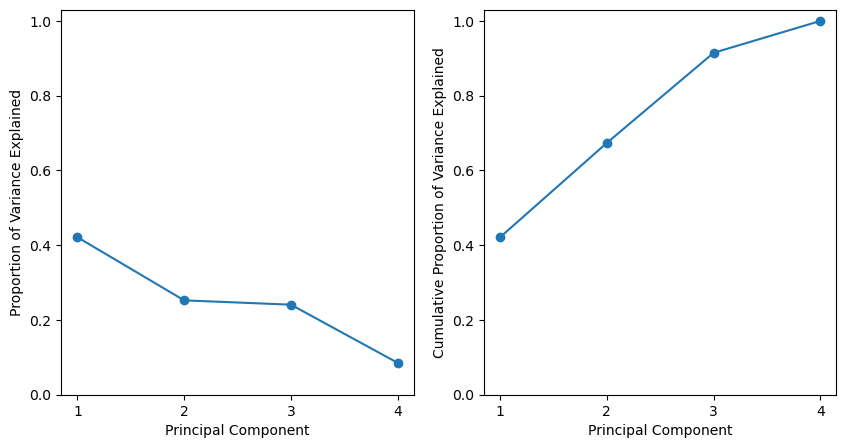

In [13]:
# scree plots (PVE and CPVE)

pve = s**2/sum(s**2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot([1,2,3,4],pve, marker="o")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Proportion of Variance Explained")
ax[0].set_ylim(0, 1.03)
ax[0].set_xticks([1, 2, 3, 4])

ax[1].plot([1,2,3,4],np.cumsum(pve), marker="o")
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Cumulative Proportion of Variance Explained")
ax[1].set_ylim(0, 1.03)
ax[1].set_xticks([1, 2, 3, 4]);

The first, second, and third principal component explain 42.1%, 25.2%, and 24.1% of the variance, respectively. Together, they explain over 90% of the variance. Of course, we would never use all 4 components, but the PVEs above show that there would be little benefit in doing so anyway; the data is approximately 3-dimensional. Unfortunately, we will have to use only the first and second principal components in our plots, which loses the structure in the non-negligble third component. Still, the first and second components explain 67.4% of the variance, so they might be enough to learn something useful about the data.

Recall that the $m^{\text{th}}$ principal component is the $m^{\text{th}}$ row of $V^\top$. We can look at the loadings (coefficients of the features) of the principal components to get a sense of how the data spreads out.

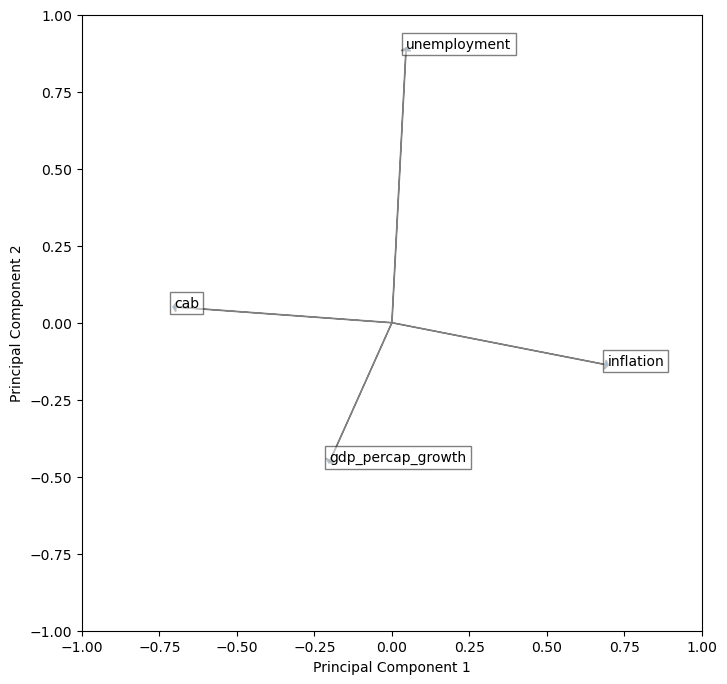

In [14]:
fig , ax = plt.subplots(figsize=(8,8))

ax.set_ylim(-1,1)
ax.set_xlim(-1,1)

# Plot principal components as arrows
for i, (comp, var) in enumerate(zip(VT.T, X.columns)):
    ax.arrow(0, 0, comp[0], comp[1], head_width=0.03, head_length=0.01,  ec='gray')
    ax.text(comp[0]*1.01, comp[1]*1.01, var, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 3})

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2");

In [15]:
loadings = pd.DataFrame(VT.T,index=X.columns,columns="PC1 PC2 PC3 PC4".split())
loadings

,PC1,PC2,PC3,PC4
cab,-0.696265,0.050734,-0.093940,0.709800
gdp_percap_growth,-0.198837,-0.446305,0.871198,-0.047844
inflation,0.688205,-0.135752,0.126051,0.701467
unemployment,0.045305,0.883068,0.465081,0.042875


The _magnitudes_ of the loadings tell us which features are the most significant in the principal components. For example, `cab` and `inflation` are the most important features in the first principal component, while `unemployment` and `gdp_percap_growth` are the most important features in the second principal component. On the other hand, the _signs_ of the loadings tell us how the features are related in the principal components. For example, the first principal component is the direction along which the data most separates. The fact that `cab` and `inflation` have opposite signs in the first component tells us that there are a lot of countries with a low current account balance and high inflation (and vice versa). The second principal component is more intuitive: it tells us that the countries with high gdp per capita growth tend to have low unemployment (and vice versa).

One possible interpretation of these principal components is as follows:
- **PC1**: The _stability_ axis. Countries with high PC1 scores experience the classic combination of economic distress: elevated inflation paired with current account deficits. On the other hand, countries with low PC1 scores exhibit characteristics of economic stability—controlled inflation alongside sustainable external positions.
- **PC2**: The _unemployment_ axis. The second principal component is dominated by the unemployment feature, making it essentially a direct measure of labor market distress. Countries with high PC2 scores have higher unemployment rates and lower GDP growth, reflecting economies where job creation has stagnated or declined.
- **PC3**: The _recovery_ axis? The third principal component captures the unusual situation in which both GDP per capita growth and unemployment are high or low. One reason why GDP per capita growth would be high at the same time unemployment is high is if the economy is recovering from a crisis or severe recession. During the early stages of economic recovery, GDP growth often resumes before labor markets fully heal, creating a short period where output expands while unemployment remains high.
- **PC4**: noise?

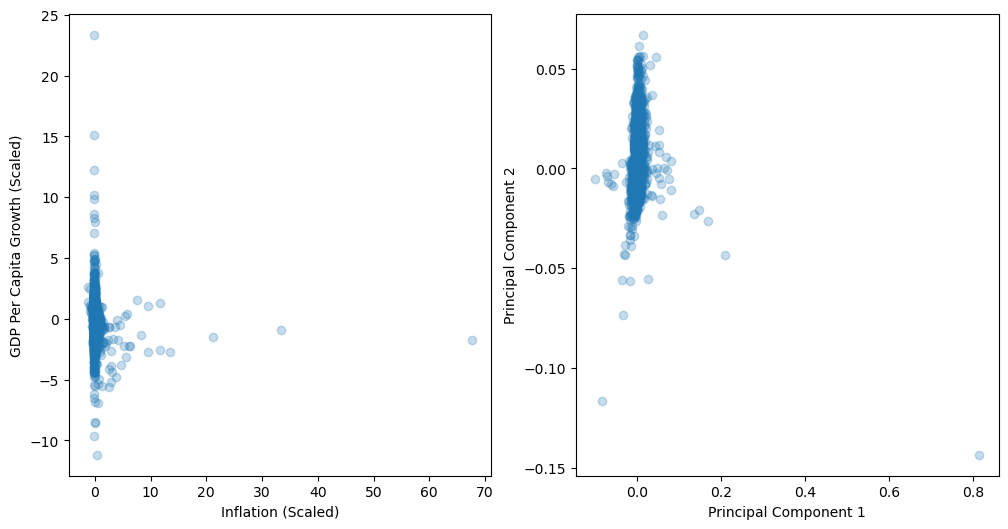

In [102]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

# inflation, gdp_percap_growth (scaled)
ax[0].scatter(X_tilde_scaled.inflation, X_tilde_scaled.gdp_percap_growth, alpha=0.25)
ax[0].set_xlabel("Inflation (Scaled)")
ax[0].set_ylabel("GDP Per Capita Growth (Scaled)")

# standardized scores of first two components
ax[1].scatter(U[:,0], U[:,1], alpha=0.25)
ax[1].set_xlabel("Principal Component 1")
ax[1].set_ylabel("Principal Component 2");

On the left, we see the data plotted with `inflation` along the x-axis and `gdp_percap_growth` along the y-axis. On the right, we see the data plotted in the first two principal components. The two plots are remarkably similar in shape, and reveal two things: One, they reveal the existence of extreme outliers. Two, they suggest that our data doesn't separate into discrete groups, but rather forms a continuum. While we like to describe economies with discrete categories (e.g., recession), the reality is that economies can exhibit varying _degrees_ of recession, or inflation, growth, or whatever pattern. While it might be possible to group _sequences_ of the data, the _flat_ datapoints don't form distinct clusters.

## 4.3 K-Means Clustering

In [17]:
# within-cluster sum of squares and silhouette score
def compute_metrics(k):
   kmeansk = KMeans(n_clusters=k, random_state=3, n_init=20).fit(U);
   silscore = metrics.silhouette_score(U, kmeansk.labels_, metric="euclidean")
   return kmeansk.inertia_, silscore

ks = np.arange(2,11)
WCSS, SS = list(zip(*[compute_metrics(k) for k in ks]))

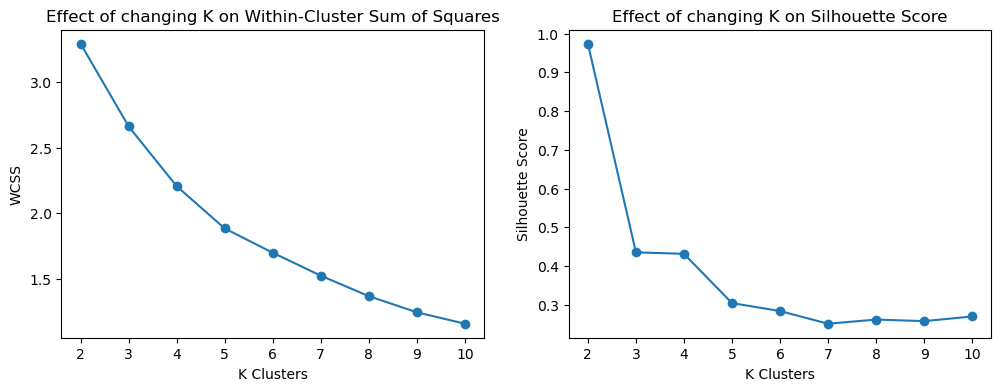

In [18]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(ks, WCSS, linestyle="-", marker="o")
ax[0].set_xlabel("K Clusters")
ax[0].set_ylabel("WCSS")
ax[0].set_title("Effect of changing K on Within-Cluster Sum of Squares")

ax[1].plot(ks, SS, linestyle="-", marker="o")
ax[1].set_xlabel("K Clusters")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Effect of changing K on Silhouette Score");

Based only on the WCSS, we'd probably choose $K=4$ or $K=5$. Based only on the silhouette scores, we'd probably choose $K=2$, $K=3$, or $K=4$. Based on both metrics, $K=4$ seems like the best choice.

In [69]:
kmeans = KMeans(n_clusters=4,random_state=5322,n_init=20).fit(U)

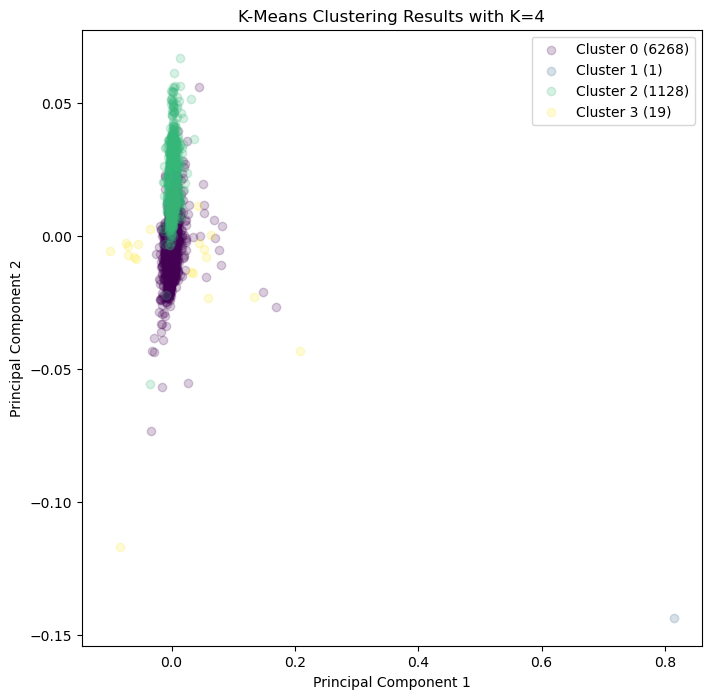

In [104]:
fig, ax = plt.subplots(figsize=(8,8))
unique_labels = np.unique(kmeans.labels_)
colors = plt.cm.viridis(np.linspace(0,1,len(unique_labels)))

for i, label in enumerate(unique_labels):
    mask = kmeans.labels_==label
    ax.scatter(
        U[mask,0],
        U[mask,1],
        alpha=0.2,
        c=[colors[i]], 
        label=f"Cluster {label} ({np.sum(mask)})"
    )

ax.set_title("K-Means Clustering Results with K=4")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend();

In [ ]:
np.random.seed(5322)

# Cluster 0
X[kmeans.labels_==0].iloc[np.random.choice(6268,10)]

,cab,gdp_percap_growth,inflation,unemployment
"Netherlands, 2010",6.625775,0.800961,1.275306,4.991
"Kuwait, 2016",0.586533,-1.431522,3.198398,2.160
"Sweden, 2011",5.510258,2.387802,2.961151,7.804
"Kuwait, 2023",31.395617,-8.877442,3.642164,2.127
"Germany, 2016",8.899854,1.472293,0.491747,4.104
"Burkina Faso, 2013",-10.008286,2.665083,0.533739,4.055
"Ghana, 1978",-1.254352,5.230091,73.091667,NaN
"Vanuatu, 2016",-9.024024,2.385571,0.842069,5.261
"Bolivia, 2006",11.504455,3.025736,4.282396,2.577
"Iran, Islamic Rep., 1979",13.240128,-14.993665,10.487237,NaN


In [ ]:
# Cluster 2
X[kmeans.labels_==2].iloc[np.random.choice(1128,10)]

,cab,gdp_percap_growth,inflation,unemployment
"Angola, 1994",-7.656048,-1.893068,949.792531,17.400
"Suriname, 2000",NaN,0.016413,59.401687,12.983
"North Macedonia, 2013",-1.637640,3.305597,2.785001,29.017
"Lithuania, 2001",-4.678135,7.365189,1.367120,16.840
"Lesotho, 2022",-11.418759,1.287456,8.271804,16.688
"Iran, Islamic Rep., 2010",NaN,4.481946,10.089363,13.679
"Djibouti, 2022",17.859382,2.282885,5.179808,26.307
"Colombia, 2009",-1.906926,-0.031705,4.202517,12.066
"Armenia, 2021",-3.479974,5.771428,7.184836,15.469
"France, 1996",1.285931,1.035285,1.982884,12.367


In [ ]:
# Cluster 1
X[kmeans.labels_==1]

,cab,gdp_percap_growth,inflation,unemployment
"Congo, Dem. Rep., 1994",NaN,-8.342473,23773.131774,3.389


In [ ]:
# Cluster 3
X[kmeans.labels_==3]

,cab,gdp_percap_growth,inflation,unemployment
"Angola, 1995",-5.326961,11.222449,2666.450593,16.987
"Angola, 1996",43.398674,9.768938,4145.105982,16.275
"Armenia, 1994",-7.891063,8.179314,3373.759443,6.600
"Belarus, 1994",-2.972253,-11.595575,2221.016570,12.800
"Bolivia, 1985",-5.305660,-3.734705,11749.639632,NaN
"Brazil, 1990",-0.822170,-6.043272,2947.732772,NaN
"Brazil, 1993",0.005430,3.238678,1927.380790,6.030
"Brazil, 1994",-0.219465,4.210940,2075.888398,6.578
"Equatorial Guinea, 1997",NaN,140.490578,3.016505,7.832
"Peru, 1989",-2.535383,-14.258158,3398.679010,NaN


Clusters 1 and 3 only have 1 and 19 samples, respectively. This, and looking at the plot, make it obvious that these clusters are collecting outliers. In particular, cluster 1 consists of a single extreme outlier in 1994 Democratic Republic of Congo (23773% inflation!), while cluster 2 consists of "tamer" outliers along the stability or external-internal imbalance axes (e.g., many of the samples in cluster 2 have extremely high inflation). Clusters 0 and 2 contain the more "normal" economic varieties. Based on the plot, the two clusters split the continuous region, mainly along PC2. It makes sense, then, that the most obvious difference between the two clusters is in unemployment (cluster 0 has low unemployment; cluster 2 has high unemployment) PC2 is essentially the unemployment axis.

In [ ]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter3D(
    U[:,0],
    U[:,1], 
    U[:,2],
    alpha=0.5,
    c=kmeans.labels_
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2") 
ax.set_zlabel("PC3")
ax.set_title("K-Means Clustering")

def rotate(frame):
    ax.view_init(elev=20,azim=frame)
    return scatter,

# Create animation (360 degree rotation)
animation = FuncAnimation(
    fig,
    rotate,
    frames=np.arange(0,360,2),
    interval=50,
    repeat=True
)

# Save as GIF
animation.save("img/kmeans_clusters.gif",writer="pillow",fps=20)

<p align="center">
	<img src="img/kmeans_clusters.gif" alt="drawing" width="600"/>
</p>

## 4.4 Hierarchical Clustering

In [ ]:
hc_ward = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    linkage="ward"
)
hc_ward.fit(U)

hc_comp = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    linkage="complete"
)
hc_comp.fit(U)

hc_avg = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    linkage="average"
)
hc_avg.fit(U)

hc_sing = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    linkage="single"
)
hc_sing.fit(U);

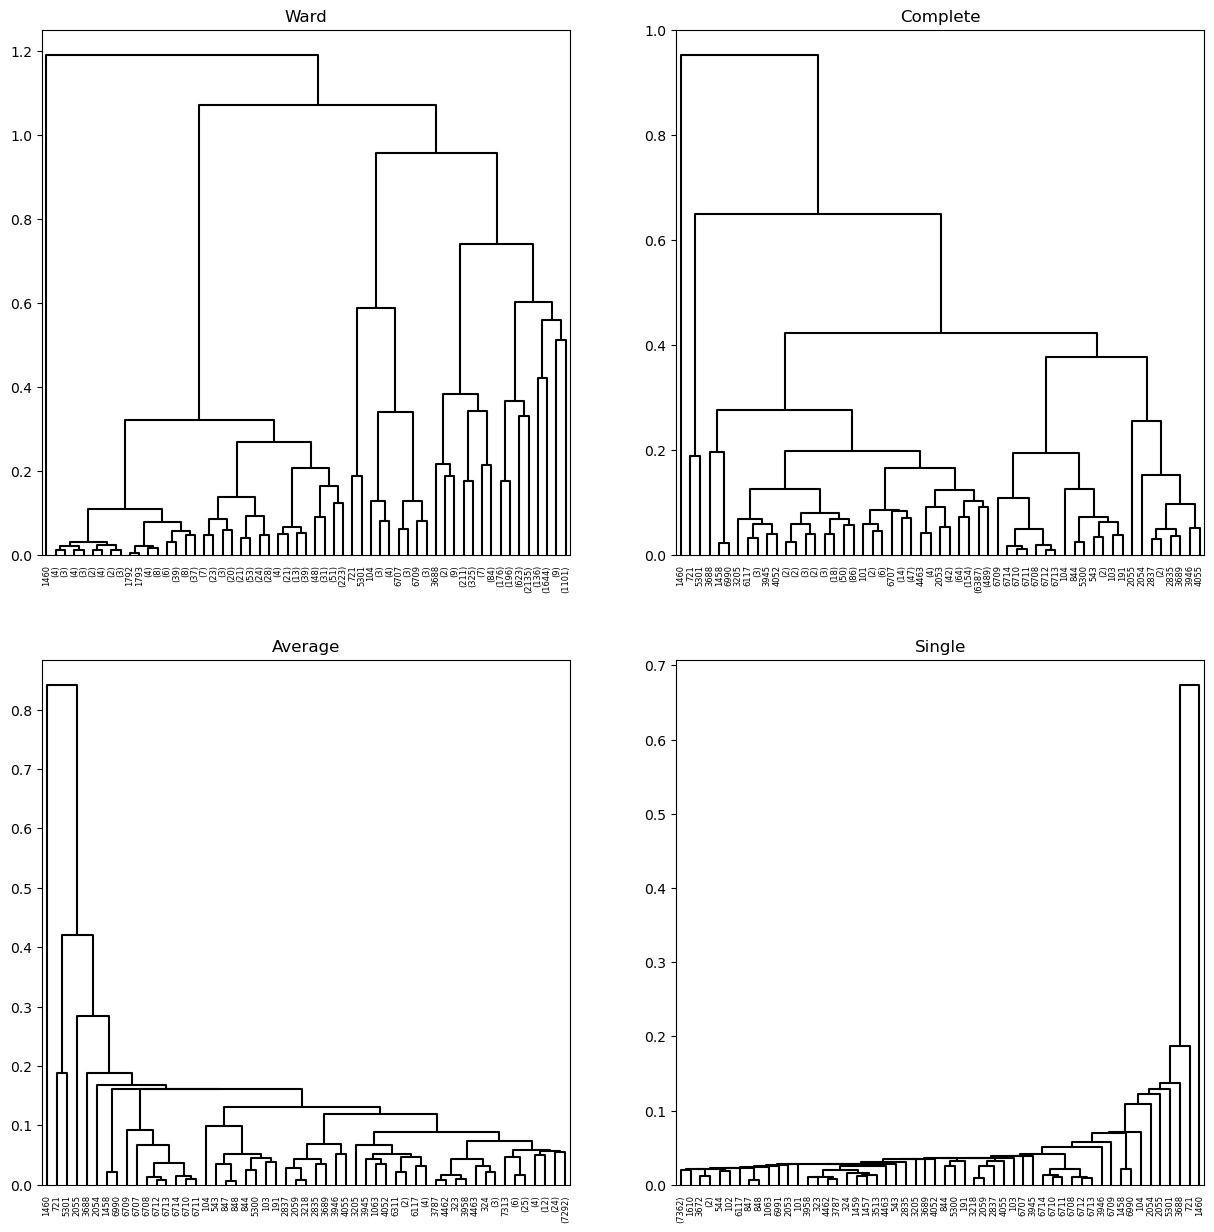

In [53]:
cargs = {"color_threshold":-np.inf, "above_threshold_color":"black"}

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,15))

axes[0,0].set_title("Ward")
dendrogram(compute_linkage(hc_ward), truncate_mode="level", p=6, ax=axes[0,0], **cargs)

axes[0,1].set_title("Complete")
dendrogram(compute_linkage(hc_comp), truncate_mode="level", p=8, ax=axes[0,1], **cargs)

axes[1,0].set_title("Average")
dendrogram(compute_linkage(hc_avg), truncate_mode="level", p=13, ax=axes[1,0], **cargs)

axes[1,1].set_title("Single")
dendrogram(compute_linkage(hc_sing), truncate_mode="level", p=30, ax=axes[1,1], **cargs);

The dendrogram with ward linkage looks the most balanced. Based on the work done in the K-Means Clustering section, 3-4 clusters seems to be about right (at least one cluster dedicated for the extreme outlier and at least two clusters for the continuous region), which is fairly consistent with the dendrogram (we wouldn't want to cut much lower than four clusters).

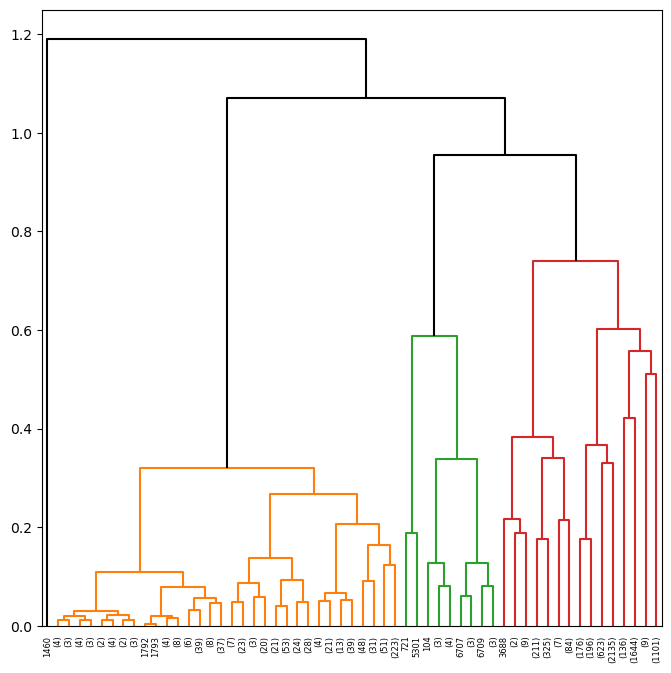

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(
    compute_linkage(hc_ward),
    truncate_mode="level", p=6,
    ax=ax,
    color_threshold=0.8,
    above_threshold_color='black'
);

In [171]:
cut4 = cut_tree(compute_linkage(hc_ward), n_clusters=4).flatten()

In [172]:
# manually determined translation from dendrogram cluster #s to kmeans cluster #s
translation = {0:0, 1:2, 2:3, 3:1}
cut4 = np.array([translation[x] for x in cut4])

In [173]:
cm = pd.DataFrame(metrics.confusion_matrix(cut4,kmeans.labels_))
cm.index = pd.Index([0,1,2,3], name="dendrogram")
cm.columns.name = "k-means"
cm

k-means,0,1,2,3
dendrogram,,,,
0,6261,0,397,1
1,0,1,0,0
2,7,0,731,0
3,0,0,0,18


The confusion matrix above shows that the k-means and hierarchical clusters are mostly the same. The biggest difference is that the hierarchical clustering moved 397 samples from cluster 2 to cluster 0. Recall that the biggest difference between 0th and 2nd k-means clusters was in unemployment. Based on the descriptions below, the migration of the 397 samples is consistent with this, with the samples being moved from cluster 2 to cluster 0 tending to have lower unemployment than the samples being kept in cluster 2.

In [ ]:
# 2 (k-means) => 0 (dendrogram)
X.loc[(cut4==0) & (kmeans.labels_==2)].describe()

,cab,gdp_percap_growth,inflation,unemployment
count,354.000000,387.000000,386.000000,397.000000
mean,-5.073743,3.122837,24.653747,13.862353
std,6.886655,8.901992,109.819548,1.430267
min,-57.107005,-49.127857,-6.687321,11.994000
25%,-8.977438,1.001063,2.061133,12.763000
50%,-4.363719,3.515888,4.765625,13.606000
75%,-1.224508,6.077915,12.255626,14.557000
max,25.757573,91.781370,1378.527607,19.641000


In [ ]:
# 2 in both
X.loc[(cut4==2) & (kmeans.labels_==2)].describe()

,cab,gdp_percap_growth,inflation,unemployment
count,681.000000,714.000000,690.000000,731.000000
mean,-4.008465,0.597925,12.247714,19.992499
std,12.015522,4.959630,36.995693,4.688055
min,-49.731844,-24.611092,-16.859691,12.145000
25%,-9.798523,-1.453795,1.740443,16.568500
50%,-3.099729,1.252319,4.390506,19.276000
75%,2.077915,3.554160,8.456750,22.168000
max,41.906588,18.848447,410.451859,38.800000


The hierarchical clustering plots are very similar to those of k-means.

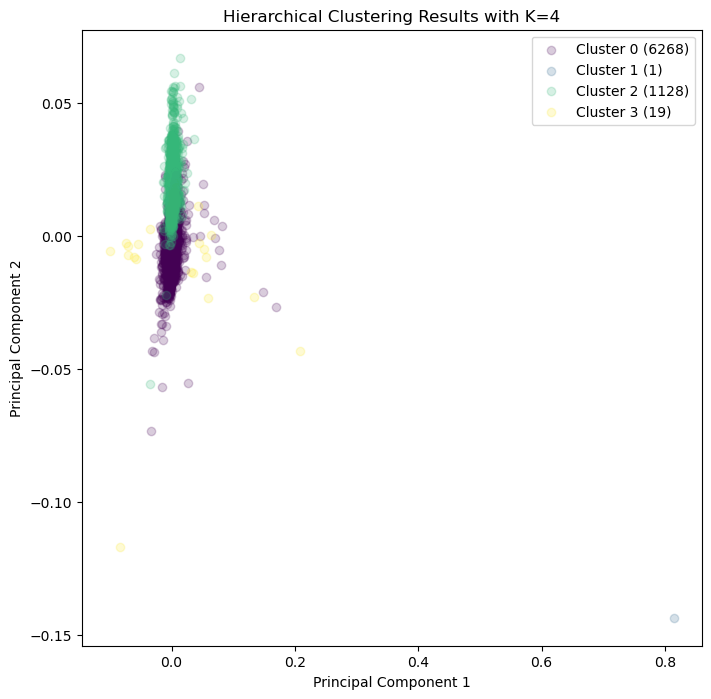

In [158]:
fig, ax = plt.subplots(figsize=(8,8))
unique_labels = np.unique(cut4)
colors = plt.cm.viridis(np.linspace(0,1,len(unique_labels)))

for i, label in enumerate(unique_labels):
    mask = kmeans.labels_==label
    ax.scatter(
        U[mask,0],
        U[mask,1],
        alpha=0.2,
        c=[colors[i]], 
        label=f"Cluster {label} ({np.sum(mask)})"
    )

ax.set_title("Hierarchical Clustering Results with K=4")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend();

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter3D(
    U[:,0],
    U[:,1], 
    U[:,2],
    alpha=0.5,
    c=cut4
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2") 
ax.set_zlabel("PC3")
ax.set_title("Agglomerative Clustering")

def rotate(frame):
    ax.view_init(elev=20,azim=frame)
    return scatter,

# Create animation (360 degree rotation)
animation = FuncAnimation(
    fig,
    rotate,
    frames=np.arange(0,360,2),
    interval=50,
    repeat=True
)

# Save as GIF
animation.save("img/agglomerative_clustering.gif",writer="pillow",fps=20)

<p align="center">
	<img src="img/agglomerative_clustering.gif" alt="drawing" width="600"/>
</p>

# 5. Discussion

In the theoretical background section, we talked about how singular value decomposition implements principal component analysis when the data is standardized; our data was standardized, and so this is exactly what we did. The rows of $V^\top$ are loadings/principal components, which gave us the directions of max variance in the data. By looking at the feature coefficients in the principal components, we were able to develop a potential interpretation for the principal components: PC1 is the _stability_ axis (high current account balance and low inflation, or vice versa), PC2 is the _unemployment_ axis, PC3 may be the "recovery" axis, and PC4 could just be the remaining noise. We used the singular values in $\Sigma$ to compute the proportion of variance explained and found that the first two principal components explain 67.4%, while the first three principal components explain over 90% of the variance. Thus, the data is approximately 3-dimensional, which is part of why we suspect the fourth principal component could just be noise.

We then plotted the data in the first two principal components using the (non-scaled) scores given by (the first two columns of) $U$. For reference, we also plotted the data using only inflation and GDP per capita growth. The two plots were remarkably similar, and reveal two things about the data. First, it revealed the existence of outliers. Second, the plots suggests that our data doesn't separate into discrete groups, but rather forms a continuum, which actually makes sense. While it can be useful/convenient to group economies into discrete buckets (recessionary, hyperinflationary, etc.), the reality is that economies can exhibit varying _degrees_ of recession, or inflation, growth, or whatever pattern. Thus, our goal of identifying discrete groups was doomed from the start because the data lies on a _continuous_ gradient. This is not to say that distinct economic _phases_ don't exist; it may very well be possible or group _sequences_ of the data into discrete groups, but that doesn't seem to be possible for the _flat_ datapoints because the context is missing.

Despite the data being seemingly unclusterable, the k-means clusters were still insightful to some extent. Two of the clusters identified a small number of outliers, typically economics facing extreme instability of some kind (e.g., hyperinflation). The other two clusters split the remaining majority of the datapoints—which lies along a continuous region—into two pieces, primarily by unemployment. This would suggest that, within the range of typical economic performance, labor market conditions serve as the primary differentiating factor, though we should take this with a grain of salt because unemployment was the feature with the most missing values (just under 25%). The hierarchical clusters were mainly the same as the k-means clusters, with the only significant difference being the migration of 397 observations from the high-unemployment cluster to the low-unemployment cluster, though this just indicates a different choice of a possibly arbitrary decision boundary.

# 6. Conclusion

In this notebook, we applied unsupervised learning techniques to macroeconomic data of all available countries from the years 1960 to 2024. The goal was to identify the distinct economic states/phases that countries experience, such as recession or hyperinflation. Instead, we found that such discrete groups _don't exist_ (at least not for the flat datapoints we analyzed), rather, economies lie on a continuous spectrum of the discrete categories we like to use. There are two directions in which this project could be taken further. First, we could retry the task with more and different data (e.g., different features), though we suspect the result wouldn't change. Second, we could try to cluster _sequences_ rather than flat datapoints (e.g., identifying a 10-year period of stable growth). This, at least, sounds promising, though we are unaware of the techniques needed to accomplish such a clustering.

# 7. References

1. Current account balance (% of GDP). World Bank Open Data. (n.d.-a). https://data.worldbank.org/indicator/BN.CAB.XOKA.GD.ZS 
2. GDP per capita growth (annual %). World Bank Open Data. (n.d.-b). https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG 
3. Heakal, R. (n.d.). Current account balance definition: Formula, components, and uses. Investopedia. https://www.investopedia.com/insights/exploring-current-account-in-balance-of-payments/ 
4. Inflation, consumer prices (annual %). World Bank Open Data. (n.d.-c). https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG 
5. Unemployment, total (% of total labor force) (modeled ILO estimate). World Bank Open Data. (n.d.-d). https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS 